# Meeting 4/27

Price increase may indicate a sale on recent previous orders. Change in average price between days. That is, compute

$$
p_d - p_{d-1}
$$

where $d$ is the day and $p_d$ is the price on day $d$.

---

Price variance within deduplicated PIDs

---

Accuracy for model we've tried:

Model | Accuracy | Important Features
----- | -------- | ------------------
All 0 | ~0.76 |
Initial CRF | 0.7746 | pid, availibility
Initial xgboost | |

---

Does changing the loss function for xgboost improve accuracy?

Does including `(day mod 7)` in the xgboost model improve accuracy?

---

Include penalty for total revenue per day in cost function?

--- 

Features group
* Vincent
* Shuhao

xgboost group
* Lingfei
* Jingyi
* Vincent
* Olivia

HMM/HSMM group
* Hugo
* Nick
* Haoran

RNN group
* Nick
* Haoran

In [4]:
library(ggplot2)

In [1]:
source("../src/data/read_dmc.R")

orig_train = read_dmc("../data/train.csv")
orig_items = read_dmc("../data/items.csv")
orig_class = read_dmc("../data/class.csv")

In [2]:
df = merge(orig_train, orig_items, by = "pid")

df = df[order(df$lineID), ]
df$quantity = df$revenue / df$price

In [10]:
order_by_day = tapply(orig_train$order, orig_train$day, sum)

order_by_day = as.numeric(order_by_day)

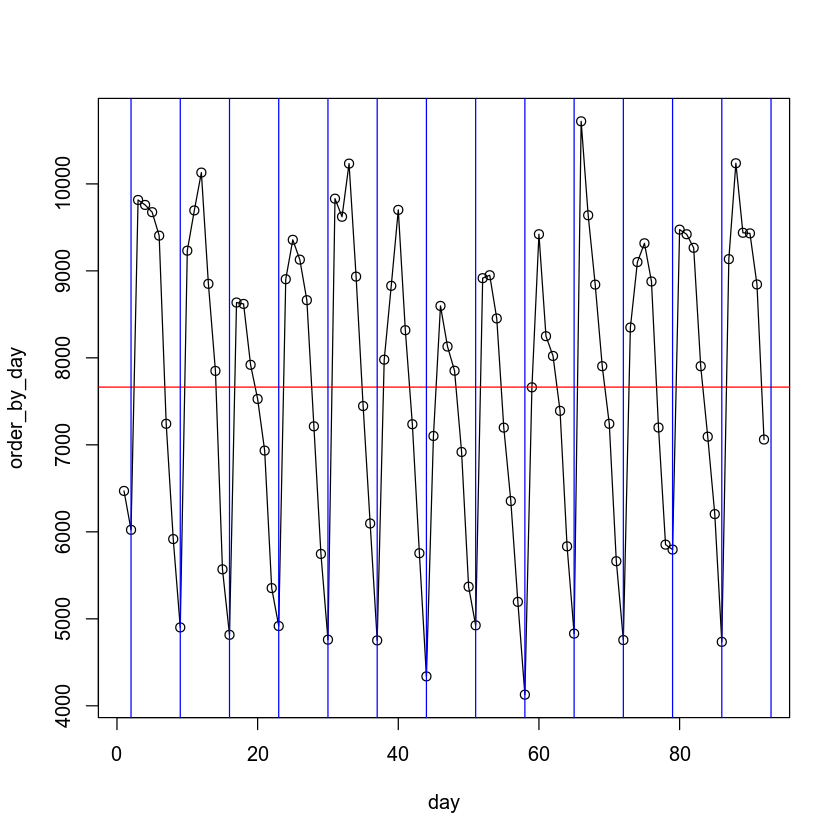

In [26]:
plot(order_by_day, type = "o", xlab = "day")
abline(h = mean(order_by_day), col = "red")
abline(v = seq(2, 100, 7), col = "blue")

In [22]:
is_ordered = orig_train$order == 1
order_price_by_day = tapply(orig_train$price[is_ordered], orig_train$day[is_ordered], mean)

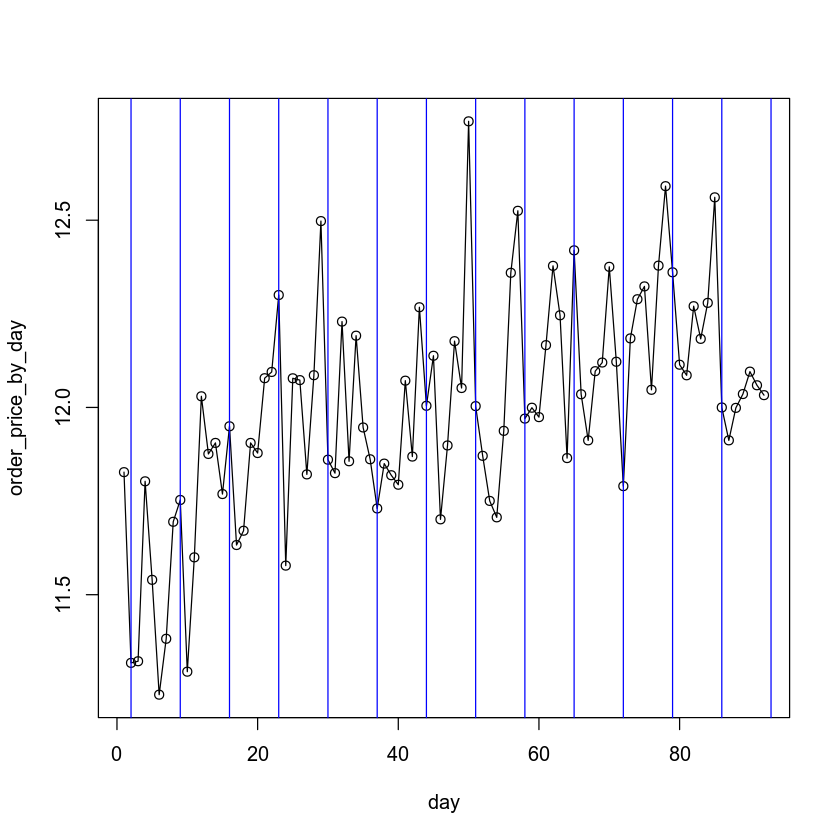

In [27]:
plot(order_price_by_day, type = "o", xlab = "day")
abline(v = seq(2, 100, 7), col = "blue")

In [39]:
revenue_by_day = tapply(orig_train$revenue, orig_train$day, sum)

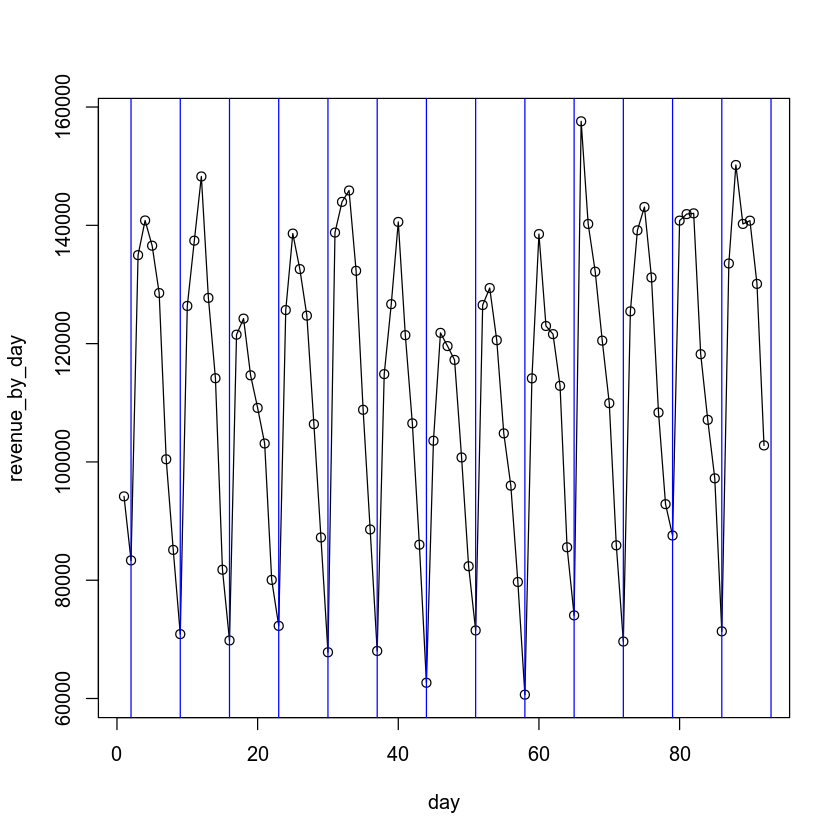

In [41]:
plot(revenue_by_day, type = "o", xlab = "day")
abline(v = seq(2, 100, 7), col = "blue")

## Fit xgboost With Better Features

In [29]:
# SETUP ----------------------------------------
set.seed(260)

source("../src/models/model_tools.R")
 
dmc = dmc_read("../data")
dmc = dmc_merge(dmc) # merge train and items 

In [31]:
dmc$day7 = dmc$day %% 7

In [ ]:
dmc = dmc_split(dmc) # split train into train and test on day 62

attach(dmc)

In [35]:
# MODEL LEVEL 1 (order) ----------------------------------------
model1 = xgboost(data = data_xgb(train), label = train$order,
    max.depth = 4, eta = 1, nthread = 4, nround = 10,
    objective = "binary:logistic")
 
preds1 = predict(model1, data_xgb(test))
preds1 = ifelse(preds1 < 0.3, 0, 1)

[1]	train-error:0.262223 
[2]	train-error:0.261323 
[3]	train-error:0.261160 
[4]	train-error:0.260986 
[5]	train-error:0.260995 
[6]	train-error:0.260714 
[7]	train-error:0.260644 
[8]	train-error:0.260537 
[9]	train-error:0.260244 
[10]	train-error:0.259958 


In [38]:
sum(diag(prop.table(table(preds1, test$order))))

[1] 0.7189267